In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline
IS_KAGGLE = True  # Small helper: if running in KAGGLE, data can be found in "../input" instead of "./input"

c:\users\wyvva\appdata\local\programs\python\python36\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\users\wyvva\appdata\local\programs\python\python36\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
c:\users\wyvva\appdata\local\programs\python\python36\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
def show_img(image_path_or_array, ax=None):
    """
    Show image.
    :param image_path_or_array: Path to image or numpy array representing the image
    :param ax: Axis where to plot. If not given, new figure is created.
    """
    if ax is None:
        plt.figure()
        ax = plt.gca()
    if isinstance(image_path_or_array, np.ndarray):
        img = image_path_or_array
    elif isinstance(image_path_or_array, str):
        try:  # Some of the images are somehow corrupt
            img = mpimg.imread(image_path_or_array) # Numpy array
        except Exception as ex:
            print("Caught exception reading the image, returning.", ex)
            return
        ax.set_title("/".join(image_path_or_array.split("/")[-2:]))
    else:
        raise RuntimeError("Unknown image type {type}".format(type=type(image_path_or_array)))
    
    ax.imshow(img)
base_img_folder = 'dataset_updated/training_set'
if IS_KAGGLE:
    base_img_folder = os.path.join( base_img_folder)
art_types = os.listdir(base_img_folder)
print(art_types)

['covid_19', 'drawings', 'engraving', 'iconography', 'lung', 'meat', 'painting', 'sculpture']


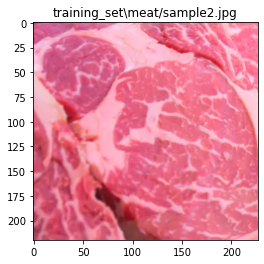

In [3]:
# style_image = "painting/0918.jpg"
# style_image = "drawings/i - 593.jpeg"
style_image = "meat/sample2.jpg"
style_reference_image_path = os.path.join(base_img_folder, style_image)
show_img(style_reference_image_path)

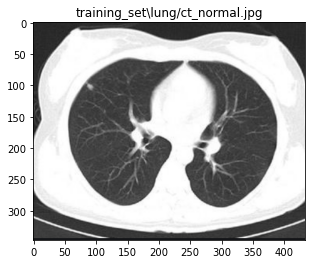

In [4]:
# target_image = "drawings/i - 655.jpeg" # Drawing of a man
# target_image = "iconography/84 18.59.20.jpg"  # Jesus icon
target_image = "lung/ct_normal.jpg"  # Painting of horse rider with angel
target_image_path = os.path.join(base_img_folder, target_image)

show_img(target_image_path)

In [5]:
from keras.preprocessing.image import load_img, img_to_array

width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)
import numpy as np
from keras.applications import vgg19

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

print("Shape of preprocessed target image:", preprocess_image(target_image_path).shape)
print("Shape of preprocessed reference image:", preprocess_image(style_reference_image_path).shape)

Using TensorFlow backend.
c:\users\wyvva\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\wyvva\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\wyvva\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

Shape of preprocessed target image: (1, 400, 500, 3)
Shape of preprocessed reference image: (1, 400, 500, 3)


In [6]:
def deprocess_image(x):
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [7]:
from keras import backend as K

target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))
combination_image = K.placeholder((1, img_height, img_width, 3))

input_tensor = K.concatenate([target_image, style_reference_image, combination_image], axis=0)

model = vgg19.VGG19(input_tensor=input_tensor,
                   weights='imagenet',
                   include_top=False)

In [8]:
def content_loss(base, combination):
    return K.sum(K.square(combination-base))
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))
def total_variation_loss(x):
    a = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - 
        x[:, 1:, :img_width - 1, :])
    b = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - 
        x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [9]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
outputs_dict

{'input_1': <tf.Tensor 'concat:0' shape=(3, 400, 500, 3) dtype=float32>,
 'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 400, 500, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 400, 500, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 200, 250, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 200, 250, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 200, 250, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 100, 125, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 100, 125, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 100, 125, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 100, 125, 256) dtype=float32>,
 'block3_conv4': <tf.Tensor 'block3_conv4/Relu:0' shape=(3, 100, 125, 256) dtype=float32>,
 'block3_pool': <t

In [10]:
content_layer = 'block5_conv2'
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(target_image_features, combination_features)

for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layers)) * sl
    
loss += total_variation_weight * total_variation_loss(combination_image)
grads = K.gradients(loss, combination_image)[0]
fetch_loss_and_grads = K.function([combination_image], [loss, grads])
class Evaluator:
    def __init__(self):
        self.loss_value = None
        self.grad_values = None
    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value
    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values
    
evaluator = Evaluator()

Start of iteration: 0
Current loss value: 3378702800.0


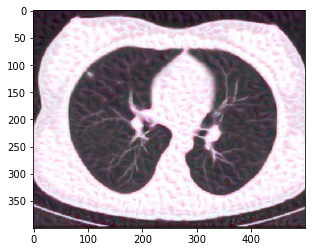

Iteration 0 completes in 595 s
Start of iteration: 1
Current loss value: 1502449000.0


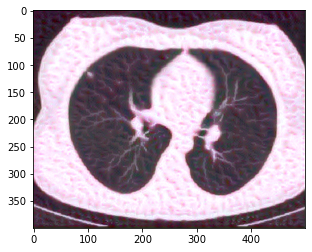

Iteration 1 completes in 583 s
Start of iteration: 2
Current loss value: 1105962600.0


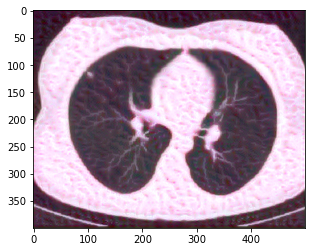

Iteration 2 completes in 578 s
Start of iteration: 3
Current loss value: 938648000.0


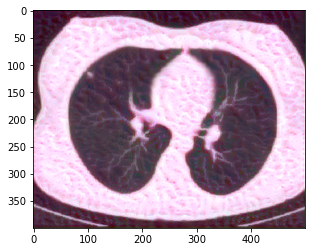

Iteration 3 completes in 578 s
Start of iteration: 4
Current loss value: 808605300.0


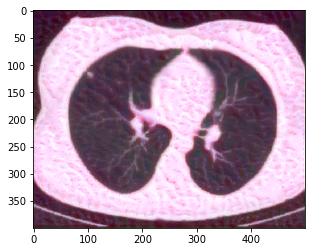

Iteration 4 completes in 380 s
Start of iteration: 5
Current loss value: 743942500.0


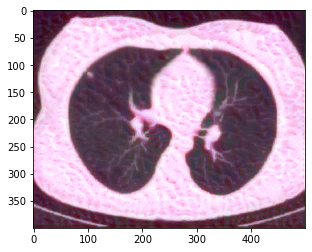

Iteration 5 completes in 308 s
Start of iteration: 6
Current loss value: 690958200.0


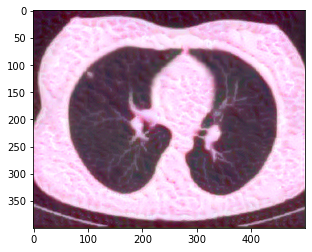

Iteration 6 completes in 317 s
Start of iteration: 7
Current loss value: 638404740.0


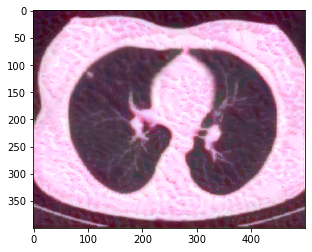

Iteration 7 completes in 345 s
Start of iteration: 8
Current loss value: 600596860.0


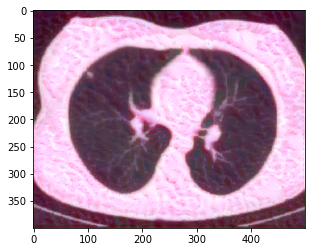

Iteration 8 completes in 328 s
Start of iteration: 9
Current loss value: 569641800.0


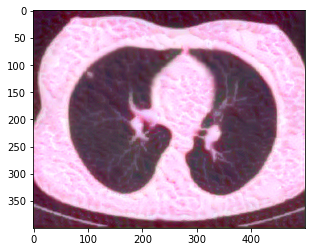

Iteration 9 completes in 341 s


In [11]:
from keras.preprocessing.image import save_img
from scipy.optimize import fmin_l_bfgs_b
import time

result_folder = 'results'
if not IS_KAGGLE and not os.path.exists(result_folder):
    os.makedirs(result_folder)

iterations = 10

x = preprocess_image(target_image_path)
x = x.flatten()

for i in range(iterations):
    print('Start of iteration: {}'.format(i))
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss,
                                    x,
                                    fprime=evaluator.grads,
                                    maxfun=20)
    print('Current loss value:', min_val)
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    if not IS_KAGGLE:
        fname = os.path.join(result_folder, 'generated_at_iteration_%d.png' % i)
        save_img(fname, img)
        print('Image saved as', fname)
    show_img(img)
    plt.show()
    end_time = time.time()
    print('Iteration %d completes in %d s' % (i, end_time - start_time))

Text(0.5, 1.0, 'Result image of covid_19 lung')

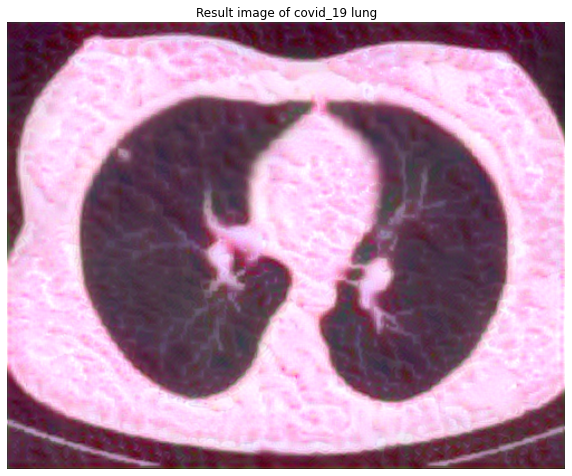

In [12]:
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = plt.gca()
plt.axis('off')
ax.imshow(img, interpolation="gaussian")
ax.set_title("Result image of covid_19 lung")